In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
btc_ts = yf.Ticker("BTC-USD").history(start='2016-01-01', end='2023-06-30')

In [18]:
btc_ts['ema12'] = btc_ts['Open'].ewm(span=12, adjust = False).mean()
btc_ts['ema26'] = btc_ts['Open'].ewm(span=26, adjust = False).mean()
btc_ts['macd'] = btc_ts['ema12'] - btc_ts['ema26']
btc_ts['signal_line'] = btc_ts['macd'].ewm(span = 9, adjust=False).mean()

<Axes: xlabel='Date'>

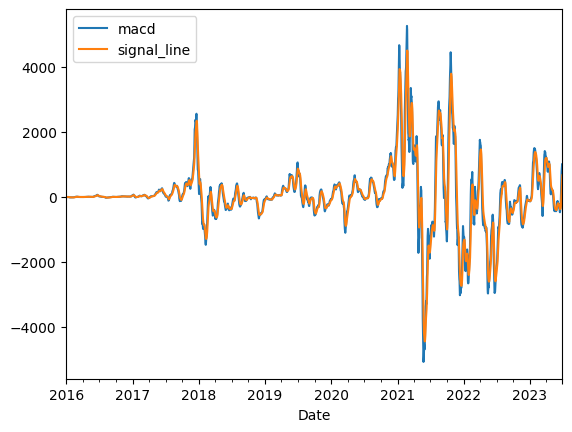

In [21]:
btc_ts[['macd','signal_line']].plot()

### Buy signal if the MACD line crosses above the slower moving signal line, sell signal when the MACD line drops below the signal line.

In [27]:
btc_ts['macd_above'] = (btc_ts['macd'] - btc_ts['signal_line'])>0
btc_ts['macd_above_lagged'] = btc_ts['macd_above'] .shift(1)
btc_ts.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ema12,ema26,macd,signal_line,cross_over,cross_over_lagged,macd_above,macd_above_lagged
Date,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,430.721008,436.246002,427.515015,434.334015,36278900,0.0,0.0,430.721008,430.721008,0.000000,0.000000,False,NaN,False,NaN
2016-01-02 00:00:00+00:00,434.622009,436.062012,431.869995,433.437988,30096600,0.0,0.0,431.321162,431.009971,0.311191,0.062238,True,False,True,False
2016-01-03 00:00:00+00:00,433.578003,433.743011,424.705994,430.010986,39633800,0.0,0.0,431.668369,431.200196,0.468173,0.143425,True,True,True,True
2016-01-04 00:00:00+00:00,430.061005,434.516998,429.084015,433.091003,38477500,0.0,0.0,431.421082,431.115811,0.305270,0.175794,True,True,True,True
2016-01-05 00:00:00+00:00,433.069000,434.182007,429.675995,431.959991,34522600,0.0,0.0,431.674608,431.260492,0.414116,0.223458,True,True,True,True


In [43]:
tc = 0.01
val = 1000
val_ts=[val]
long=False
for cnt, row in enumerate(btc_ts[['Open','macd_above','macd_above_lagged']].iterrows()):
    if (row[1]['macd_above']==True)  and (row[1]['macd_above_lagged']==False) and long==False:
        shares = ((1-tc)*val)/row[1]['Open']
        long=True
    elif (row[1]['macd_above']==False)  and (row[1]['macd_above_lagged']==True) and long==True:
        val = (1-tc)*shares*row[1]['Open']
        val_ts.append(val)
        long=False
    if cnt == len(btc_ts) and long:
        val = shares*row[1]['Open']
        val_ts.append(val)

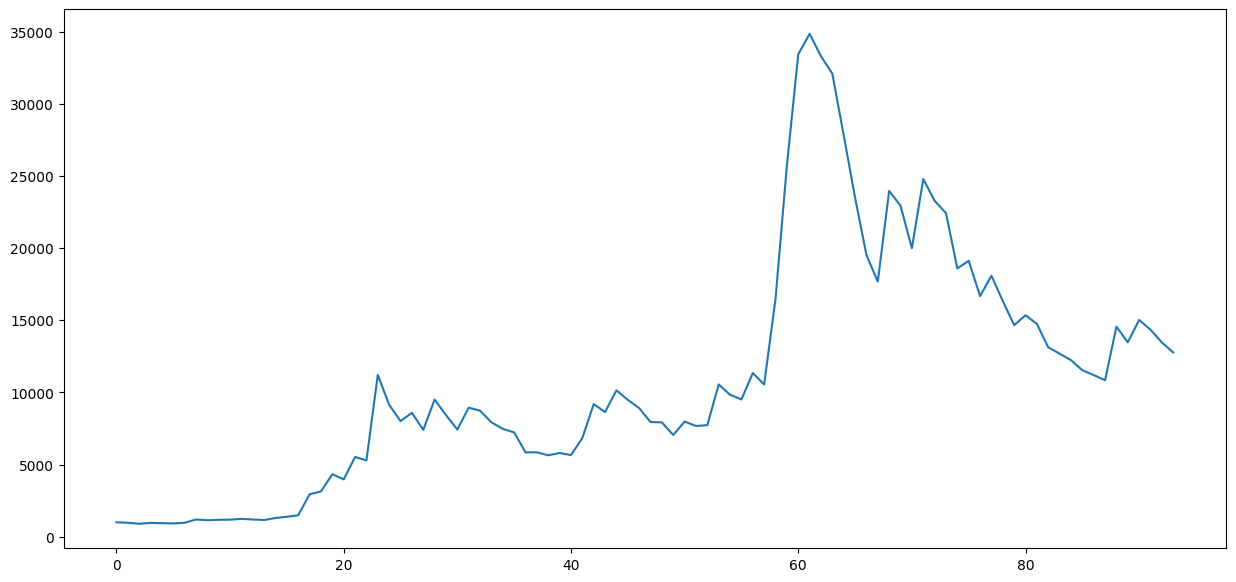

In [48]:
plt.figure(figsize = (15,7))
plt.plot(range(len(val_ts)),val_ts)

In [8]:
def get_macd_value(df, val = 1000 , tc = 0.01):
    val_ts=[val]
    long=False

    # Add the required columns to the DF:
    df['ema12'] = df['Open'].ewm(span=12, adjust = False).mean()
    df['ema26'] = df['Open'].ewm(span=26, adjust = False).mean()
    df['macd'] = df['ema12'] - df['ema26']
    df['signal_line'] = df['macd'].ewm(span = 9, adjust=False).mean()
    
    df['macd_above'] = (df['macd'] - df['signal_line'])>0
    df['macd_above_lagged'] = df['macd_above'] .shift(1)

    #Impliment the trading strategy:
    for cnt, row in enumerate(df[['Open','macd_above','macd_above_lagged']].iterrows()):
        if (row[1]['macd_above']==True)  and (row[1]['macd_above_lagged']==False) and long==False:
            shares = ((1-tc)*val)/row[1]['Open']
            long=True
        elif (row[1]['macd_above']==False)  and (row[1]['macd_above_lagged']==True) and long==True:
            val = (1-tc)*shares*row[1]['Open']
            val_ts.append(val)
            long=False
        if cnt == len(df) and long:
            val = shares*row[1]['Open']
            val_ts.append(val)
    return val, val_ts

In [10]:
val,val_ts = get_macd_value(btc_ts)
val

12763.022565833196